## Test SPIM data CEBRA model

- Use CEBRA time contrastive learning on neural data from one fish, train decoder on eye position
    - design model
    - convert SPIM neural and data to usable format 
    - load data
    - fit
    - plot embeddings
    - try to decode eye position and compare it to the ElasticNet models
        - decoding of eye position (or tail vig) should work a lot better than stimulus response, because our discrete variables are very sparse<br/><br/>



### Decoding eye position

In [4]:
import cebra
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [11]:
# # gobal params
# # global params

# list of all data files
dat_files = ['/media/storage/DATA/lfads_export/f1_221027.h5',
             '/media/storage/DATA/lfads_export/f1_221103.h5',
             '/media/storage/DATA/lfads_export/f2_221103.h5',
             '/media/storage/DATA/lfads_export/f3_221103.h5']

global FILENAME
global TIMESTEPS
global ROIS
global ITERS

FILENAME = dat_files[0]
TIMESTEPS = 5000
ROIS = 10000
ITERS = 15000

In [7]:
# # Define model

cebra_time_model = cebra.CEBRA(
    model_architecture='offset10-model',
    device='cuda_if_available',
    conditional='time',
    temperature_mode='auto',
    min_temperature=0.1,
    time_offsets=10,
    max_iterations=10000,
    max_adapt_iterations=500,
    batch_size=None,
    learning_rate=1e-4,
    output_dimension=3,
    verbose=True,
    num_hidden_units=32,
    hybrid=False
    )
print(cebra_time_model)


CEBRA(conditional='time', learning_rate=0.0001,
      model_architecture='offset10-model', output_dimension=3,
      temperature_mode='auto', time_offsets=10, verbose=True)


In [8]:
# # Load data 

# for a single fish
filename = FILENAME
filename_trunc = filename.split('/')[-1][:-3] # fish and date only
print("Accessing data...")

# extract eye position and neural data
# do not attempt to load the entire file 
with h5py.File(filename, 'r') as f:

    # eye position
    eye_pos_l = f['visuomotor']['eye_pos']['Left']
    eye_pos_r = f['visuomotor']['eye_pos']['Right']
    print(f"Full eye position dataset shape is: {eye_pos_l.shape}")

    # neural 
    neural = f['rois']['dfof']
    print(f"Full neural dataset shape is: {neural.shape}")

    # select first x timesteps and random y neurons
    # neural
    neural_indexes = np.sort(
                        np.random.choice(
                                    np.arange(neural.shape[1]), size=ROIS, replace=False
                                    )
                        )
    neural = np.array(neural[:TIMESTEPS, neural_indexes])

    # eye position
    eye_pos_l = np.array(eye_pos_l[:1000])
    eye_pos_r = np.array(eye_pos_r[:1000])

    print(f"Truncated dataset shapes are:\n \
            eye_pos_l: {eye_pos_l.shape}\n \
            eye_pos_r: {eye_pos_r.shape}\n \
            neural: {neural.shape}")

    assert(neural.shape == (TIMESTEPS, ROIS))


    # save datasets
    filename_eye_pos = f'eye_pos{filename[-12:-3]}_eye_pos.npz'
    filename_dfof = f'{filename[-12:-3]}_dfof.npz'
    np.savez(f'{filename_eye_pos}', eye_pos_l=eye_pos_l, eye_pos_r=eye_pos_r)
    np.savez(f'{filename_dfof}', neural=neural)

print("Data accessed.")

eye_pos_l = cebra.load_data(filename_eye_pos, key="eye_pos_l")
print(f"{filename_eye_pos}_left loaded.")
eye_pos_r = cebra.load_data(filename_eye_pos, key="eye_pos_r")
print(f"{filename_eye_pos}_right loaded.")
neural = cebra.load_data(filename_dfof, key="neural")
print(f"{filename_dfof} loaded.")




Accessing data...
Full eye position dataset shape is: (43350,)
Full neural dataset shape is: (43350, 93122)
Truncated dataset shapes are:
             eye_pos_l: (1000,)
             eye_pos_r: (1000,)
             neural: (5000, 10000)
Data accessed.
eye_posf1_221027_eye_pos.npz_left loaded.
eye_posf1_221027_eye_pos.npz_right loaded.
f1_221027_dfof.npz loaded.


In [9]:
# # Fit model
cebra_time_model.fit(neural)
model_name = f"{filename_trunc}_time_{TIMESTEPS}points_{ROIS}rois_{ITERS}iters.pt"
cebra_time_model.save(f'models/{model_name}')

pos:  0.3866 neg:  7.7958 total:  8.1825 temperature:  1.0817: 100%|██████████| 10000/10000 [05:34<00:00, 29.88it/s]


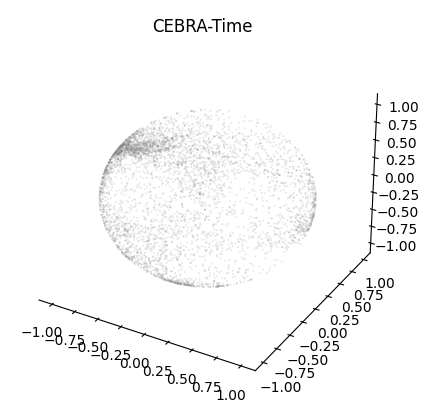

In [10]:
# # Create and plot model output

output_dims = 3

cebra_time_model = cebra.CEBRA.load(model_name)
embedding = cebra_time_model.transform(neural)
cebra.plot_embedding(embedding, title='CEBRA-Time', cmap='cool')


assert(embedding.shape == (TIMESTEPS, output_dims))

In [ ]:
# # Decode


In [ ]:
# # decode response yes/no